In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.4 MB/s eta 0:00:00
Mounted at /content/gdrive


In [4]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [5]:
!pip install kaggle

In [6]:
creds = ''

In [7]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [8]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [9]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:01<00:00, 47.0MB/s]


(#7) [Path('/root/.fastai/archive/bluebook-for-bulldozers/Test.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/Valid.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv')]

In [10]:
Path.BASE_PATH = path

In [13]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.head(4)

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN


In [14]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [15]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [16]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [17]:
df['ProductSize'] = df['ProductSize'].astype('category')

In [18]:
df['ProductSize'].dtype

CategoricalDtype(categories=['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini',
                  'Small'],
, ordered=False)

In [19]:
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)
df['ProductSize'].dtype

CategoricalDtype(categories=['Large', 'Large / Medium', 'Medium', 'Small', 'Mini',
                  'Compact'],
, ordered=True)

In [20]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [21]:
df = add_datepart(df, 'saledate')

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [23]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [24]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [25]:
procs = [Categorify, FillMissing]

In [26]:
cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
val_idx = np.where(~cond)[0]
splits = (list(train_idx),list(val_idx))
train_idx, val_idx

(array([     0,      1,      2, ..., 412695, 412696, 412697]),
 array([ 22915,  22916,  22917, ..., 401122, 401123, 401124]))

In [27]:
cont, cat = cont_cat_split(df, dep_var=dep_var)

In [28]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [29]:
to.show(3)

,datasource,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleMonth,saleDayofweek,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleWeek,saleDay,saleDayofyear,saleElapsed,SalePrice
0,121,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,11,3,False,False,False,False,False,False,False,False,1139246,999089,3157,3.0,2004,68.0,2006,46,16,320,1.163635e+09,11.097410
1,121,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,3,4,False,False,False,False,False,False,False,False,1139248,117657,77,3.0,1996,4640.0,2004,13,26,86,1.080259e+09,10.950807
2,121,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2,3,False,False,False,False,False,False,False,False,1139249,434808,7009,3.0,2001,2838.0,2004,9,26,57,1.077754e+09,9.210340


In [30]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [31]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [32]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [33]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [34]:
save_pickle(path/'to.pkl',to)

In [35]:
to = load_pickle(path/'to.pkl')

In [36]:
xs, ys = to.train.xs, to.train.ys
xs_val, ys_val = to.valid.xs, to.valid.ys

In [37]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, ys)

DecisionTreeRegressor(max_leaf_nodes=4)

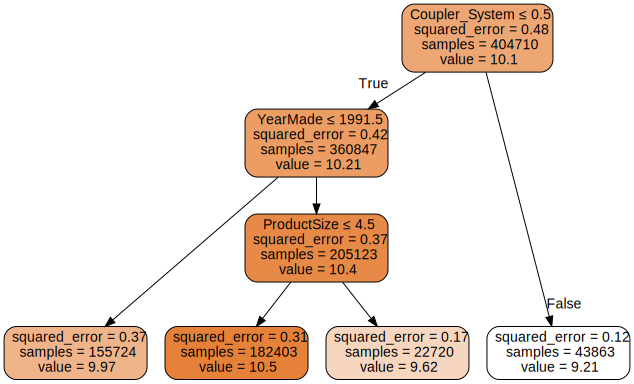

In [38]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [39]:
m = DecisionTreeRegressor()
m.fit(xs, ys)

DecisionTreeRegressor()

In [40]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [41]:
m.predict(xs).shape, ys.shape

((404710,), (404710, 1))

In [42]:
m_rmse(m, xs, np.array(ys['SalePrice'].tolist()))

0.0

In [43]:
m_rmse(m, xs_val, np.array(ys_val['SalePrice'].tolist()))

0.331075

In [44]:
len(xs), m.get_n_leaves()

(404710, 324599)

In [45]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)

DecisionTreeRegressor(min_samples_leaf=25)

In [46]:
m_rmse(m, xs, np.array(ys['SalePrice'].tolist()))

0.211677

In [47]:
m_rmse(m, xs_val, np.array(ys_val['SalePrice'].tolist()))

0.26813

In [48]:
len(xs), m.get_n_leaves()

(404710, 12397)

In [49]:
!pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

ERROR: Invalid requirement: '—pre'


In [50]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [51]:
y = np.array(ys['SalePrice'].tolist())
y_val = np.array(ys_val['SalePrice'].tolist())

In [52]:
m = rf(xs, y)

In [53]:
m_rmse(m, xs, y), m_rmse(m, xs_val, y_val)

(0.170837, 0.233235)

In [54]:
preds = np.stack([t.predict(xs_val) for t in m.estimators_])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X 

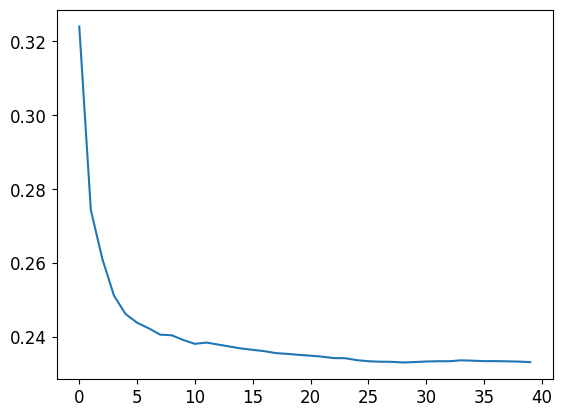

In [55]:
plt.plot([r_mse(preds[:i+1].mean(0), y_val) for i in range(40)]);

In [56]:
r_mse(m.oob_prediction_, y)

0.210684

In [57]:
pred = np.stack([t.predict(xs_val) for t in m.estimators_])
pred.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X 

(40, 7988)

In [58]:
preds_std = preds.std(0)
preds_std[:5]

array([0.26077516, 0.08886387, 0.10750411, 0.25818029, 0.15803011])

In [59]:
def rf_to_feat_importance(df, m):
  return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [60]:
fi = rf_to_feat_importance(xs, m)
fi

,cols,imp
59,YearMade,0.177017
7,ProductSize,0.113576
31,Coupler_System,0.094596
8,fiProductClassDesc,0.075876
32,Grouser_Tracks,0.071794
...,...,...
49,saleIs_quarter_end,0.000012
48,saleIs_month_start,0.000011
50,saleIs_quarter_start,0.000010
52,saleIs_year_start,0.000000


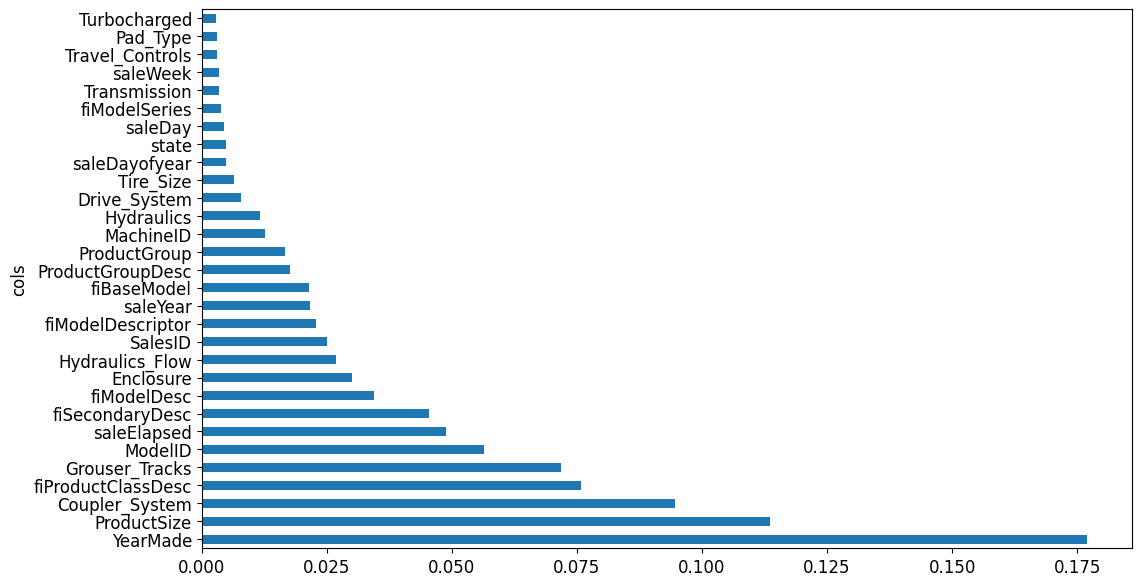

In [61]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [62]:
fi.head(3)

,cols,imp
59,YearMade,0.177017
7,ProductSize,0.113576
31,Coupler_System,0.094596


In [63]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

21

In [64]:
xs_imp = xs[to_keep]
val_xs_imp = xs_val[to_keep]

In [65]:
m = rf(xs_imp, y)

In [66]:
m_rmse(m, xs_imp, y), m_rmse(m, val_xs_imp, y_val)

(0.181048, 0.230914)

In [67]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

<Axes: ylabel='cols'>

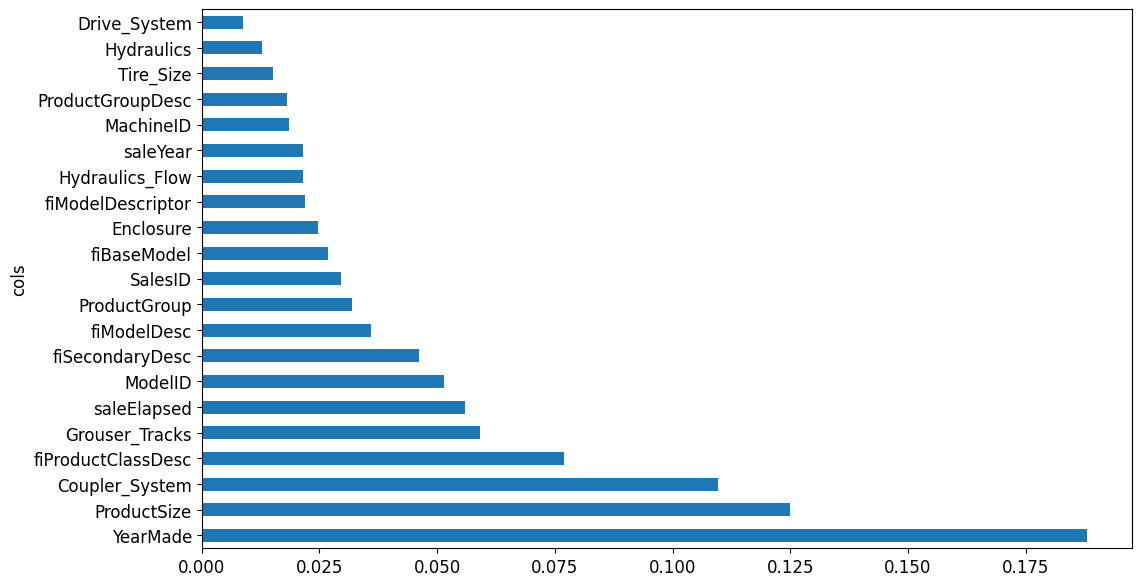

In [68]:
plot_fi(rf_to_feat_importance(xs_imp, m))

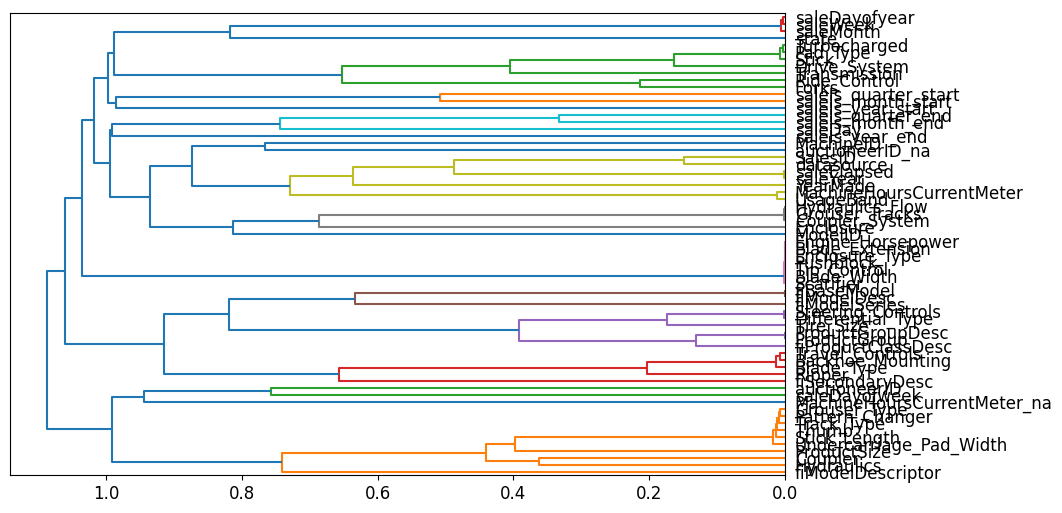

In [69]:
cluster_columns(xs)

In [70]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                            max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
  m.fit(df, y)
  return m.oob_score_

In [72]:
get_oob(xs_imp)

0.8768242026572645

In [73]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8768320730489094,
 'saleElapsed': 0.8723270550725234,
 'ProductGroupDesc': 0.8775340835749255,
 'ProductGroup': 0.8776963965795481,
 'fiModelDesc': 0.8756733911239114,
 'fiBaseModel': 0.8757143891435043,
 'Hydraulics_Flow': 0.8774921525157033,
 'Grouser_Tracks': 0.8777409805348357,
 'Coupler_System': 0.8765984135327138}

In [74]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8744252169474431

In [76]:
xs_final = xs_imp.drop(to_drop, axis=1)
val_xs_imp_final = val_xs_imp.drop(to_drop, axis=1)

In [77]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'val_xs_imp_final.pkl', val_xs_imp_final)

In [81]:
xs_final = load_pickle(path/'xs_final.pkl')
val_xs_imp_final = load_pickle(path/'val_xs_imp_final.pkl')

In [82]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, val_xs_imp_final, y_val)

(0.183382, 0.233291)

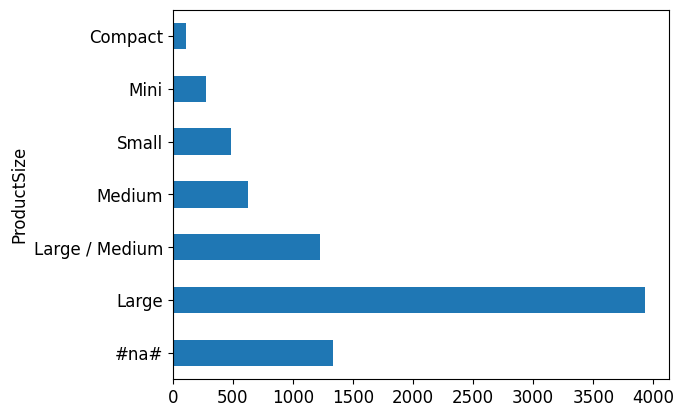

In [119]:
p = val_xs_imp_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

In [93]:
xs_final.loc[xs_final['YearMade']<1900, 'YearMade'] = 1950
val_xs_imp_final.loc[val_xs_imp_final['YearMade']<1900, 'YearMade'] = 1950

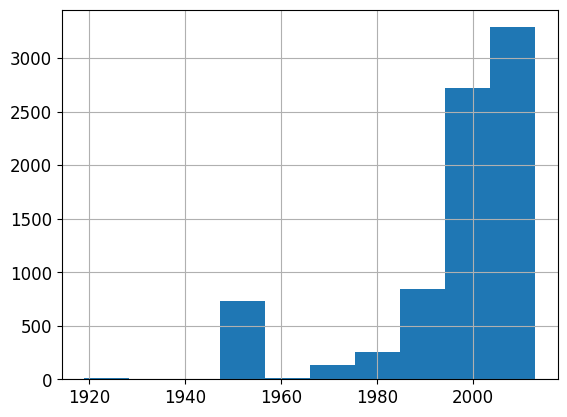

In [94]:
val_xs_imp_final['YearMade'].hist();

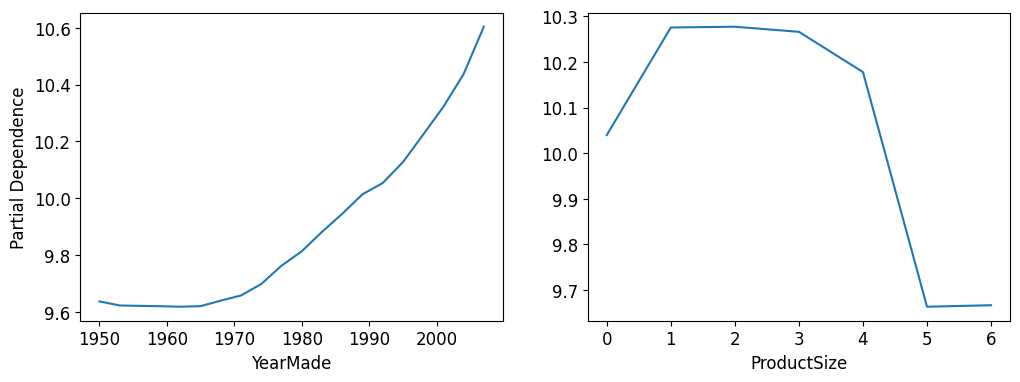

In [120]:
from sklearn.inspection import partial_dependence

fig,axs = plt.subplots(1, 2, figsize=(12, 4))
p_year_made = partial_dependence(m, val_xs_imp_final, ['YearMade'], grid_resolution=20)
p_product_size = partial_dependence(m, val_xs_imp_final, ['ProductSize'], grid_resolution=20)
p_year_made
axs[0].plot(p_year_made['values'][0], p_year_made['average'][0]);
axs[0].set_xlabel('YearMade')
axs[0].set_ylabel('Partial Dependence')
axs[1].set_xlabel('ProductSize')
c = to.classes['ProductSize']
axs[1].plot(p_product_size['values'][0], p_product_size['average'][0]);

In [121]:
!pip install treeinterpreter
!pip install waterfallcharts

In [122]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [123]:
row = val_xs_imp_final[:5]

In [124]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [125]:
prediction[0], bias[0], contributions[0].sum()

(array([9.89368017]), 10.10434023018098, -0.21066005791312817)

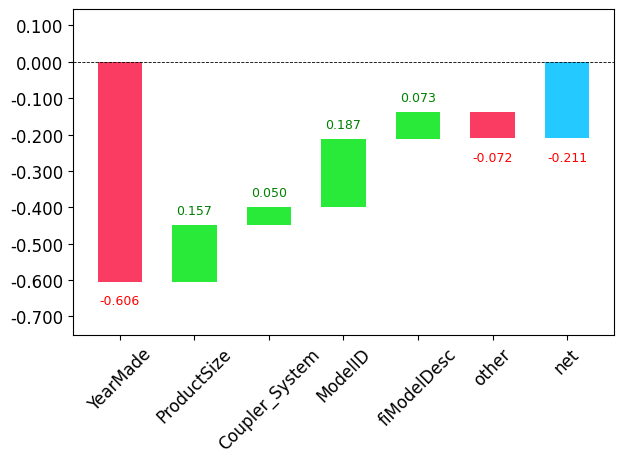

In [126]:
waterfall(val_xs_imp_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');

In [127]:
np.random.seed(42)

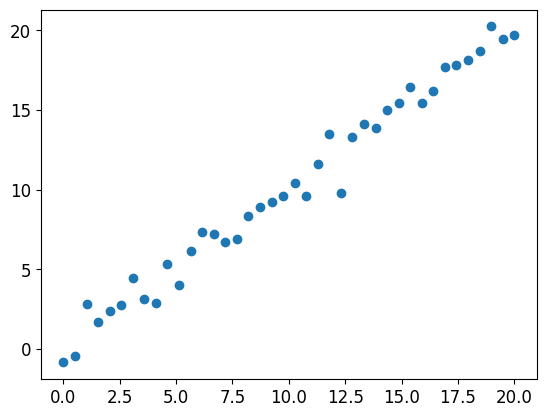

In [129]:
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [130]:
xs_lin = x_lin[:, None]
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [131]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

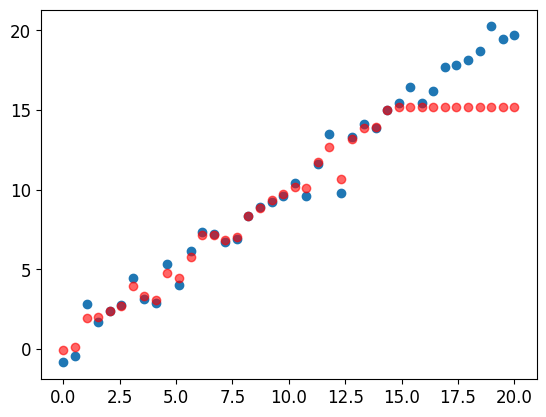

In [133]:
plt.scatter(x_lin, y_lin);
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.6);

In [135]:
df_dom = pd.concat([xs_final, val_xs_imp_final])
is_valid = np.array([0]*len(xs_final)+[1]*len(val_xs_imp_final))
m = rf(df_dom, is_valid)
rf_to_feat_importance(df_dom, m)[:6]

,cols,imp
5,saleElapsed,0.888800
10,SalesID,0.084074
13,MachineID,0.022788
4,ModelID,0.000908
0,YearMade,0.000530
3,fiProductClassDesc,0.000485


In [138]:
m = rf(xs_final, y)
print('orig', m_rmse(m, val_xs_imp_final, y_val))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, val_xs_imp_final.drop(c,axis=1), y_val))

orig 0.231606
SalesID 0.230491
saleElapsed 0.234297
MachineID 0.232308


In [139]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = val_xs_imp_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, y_val)

0.229764

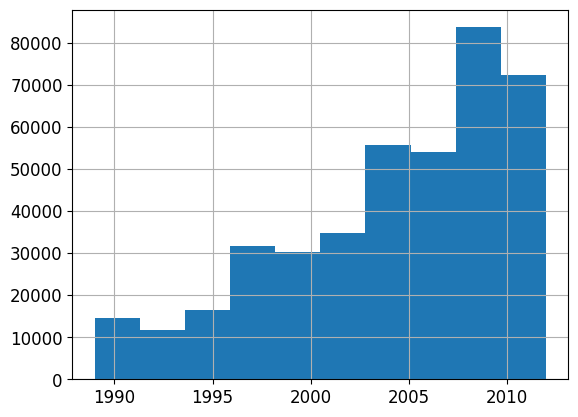

In [140]:
xs['saleYear'].hist();

In [141]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [142]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, y_val)

(0.17762, 0.230349)

In [144]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'] = df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [145]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [146]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [151]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics_Flow          3
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [152]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, y_val)

(0.176379, 0.229095)

In [153]:
cat_nn.remove('fiModelDescriptor')

In [155]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [158]:
dls = to_nn.dataloaders(1024)

In [159]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [160]:
learn = tabular_learner(dls, y_range=(8, 12), layers=[500, 250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00015848931798245758)

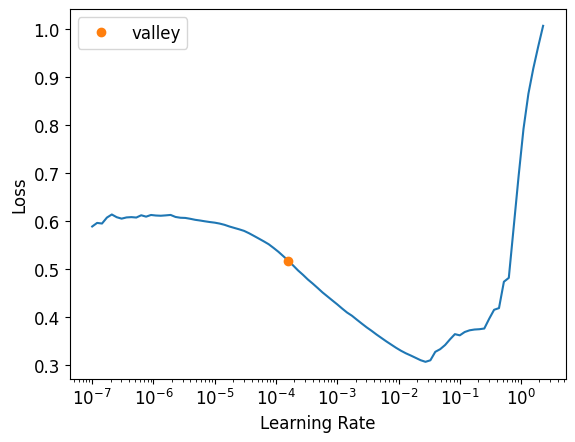

In [161]:
learn.lr_find()

In [162]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062005,0.058021,00:42
1,0.051547,0.067103,00:46
2,0.046691,0.055087,00:37
3,0.041891,0.054028,00:41
4,0.040224,0.052080,00:39


In [163]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.22821

In [167]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2
r_mse(ens_preds,y_val)

0.223659